# Get the Data

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

In [17]:
import tensorflow as tf
#from tensorflow import keras
import keras
print(tf.__version__)
print(keras.__version__)

2.16.1
3.0.5


# Get the Data

In [47]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()
maneuvers.shape

(1076, 8)

In [19]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,1076.000000,1076.000000,1.076000e+03,1076.000000,1.076000e+03,1076.000000,1.076000e+03,1.076000e+03
mean,1884.239384,-0.990435,8.281041e-07,-0.000181,3.672905e-07,0.000003,-3.531896e-07,-3.745304e-07
std,1089.383951,0.001026,3.228151e-03,0.000774,2.148905e-03,0.006637,1.596921e-03,8.038508e-07
min,0.000000,-0.991697,-4.563797e-03,-0.001314,-3.268495e-03,-0.009103,-2.401273e-03,-2.843359e-06
25%,942.119700,-0.991471,-3.224363e-03,-0.000942,-1.986743e-03,-0.006574,-1.600085e-03,-8.949463e-07
50%,1884.239500,-0.990592,1.526079e-05,-0.000236,5.841051e-06,-0.000419,-9.748682e-06,-3.095703e-07
75%,2826.359250,-0.989401,3.248570e-03,0.000581,1.975414e-03,0.006472,1.603126e-03,2.357666e-07
max,3768.479000,-0.988843,4.559389e-03,0.001052,3.271815e-03,0.010038,2.396751e-03,1.135547e-06


## Add/Drop Features

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [20]:
maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)

# Prepare the Data for Machine Learning Algorithms

In [21]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers["dv_st"].copy()
maneuvers_predictors.head()
#maneuvers_labels.head()

,x,y,z,dx,dy,dz,angle
0,-0.991363,0.003706,0.000421,0.001651,0.005402,-0.001851,0.000000
1,-0.990182,0.004321,-0.000465,0.003244,-0.002665,-0.001851,0.446335
2,-0.988990,0.001680,-0.001057,0.001518,-0.008382,-0.000670,0.892670
3,-0.989104,-0.002210,-0.001006,-0.001969,-0.007873,0.000886,1.339000
4,-0.990391,-0.004458,-0.000341,-0.003187,-0.001520,0.001944,1.785344


## Create a Train/Test Set

In [48]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
maneuvers_predictors, maneuvers_labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(
X_train_full, y_train_full)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
X_train.head()

(645, 7)
(216, 7)
(215, 7)


,x,y,z,dx,dy,dz,angle
962,-0.988968,-0.001526,-0.001247,-0.001380,-0.008570,0.000700,1.082280
732,-0.991682,-0.000771,0.000992,-0.000167,0.009843,0.000484,2.439104
220,-0.990630,0.004529,-0.000199,0.003033,-0.000151,-0.002079,0.298495
790,-0.988973,0.001572,-0.001210,0.001421,-0.008530,-0.000705,0.793922
693,-0.990296,0.004425,-0.000451,0.003245,-0.002125,-0.002121,0.328075


In [23]:
# Scale all the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:5]

array([[0.32421259, 0.00124609, 0.50260853, 0.05218084, 0.50876278,
        0.9933804 , 0.5648182 ],
       [0.56563781, 0.03465484, 0.30299419, 0.00125028, 0.30531051,
        0.91803751, 0.52472936],
       [0.01089584, 0.60777713, 0.94903959, 0.53302608, 0.98291624,
        0.37844669, 0.88057504],
       [0.54286515, 0.97315011, 0.31721512, 0.99942181, 0.3224109 ,
        0.06860762, 0.1136924 ],
       [0.5126651 , 0.01966596, 0.34015848, 0.00100927, 0.34641792,
        0.94260116, 0.53097596]])

# Building, Training, and Evaluating the Model

The output layer has a single neuron (since we only want to
predict a single value) and uses no activation function, and the loss function is the mean squared error. 

Since the dataset is quite noisy, we just use a single hidden layer with fewer neurons than before, to avoid overfitting.

In [24]:
model = keras.models.Sequential([
keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(1)
])
model.summary()

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 300)            │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,601 (127.35 KB)

 Trainable params: 32,601 (127.35 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(loss="mean_squared_error", optimizer="adam")
history = model.fit(X_train_scaled, y_train, epochs=25, 
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0124 - val_loss: 0.0012
Epoch 2/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4526e-04 - val_loss: 4.4873e-05
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4251e-05 - val_loss: 1.8123e-05
Epoch 4/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2192e-05 - val_loss: 7.6959e-06
Epoch 5/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1145e-06 - val_loss: 5.5745e-06
Epoch 6/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7681e-06 - val_loss: 4.5564e-06
Epoch 7/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9299e-06 - val_loss: 3.9724e-06
Epoch 8/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7804e-06 - val_loss: 3.3554e-06
Epoch 9/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2370e-06 - val_loss: 3.1762e-06
Epoch 10/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7632e-06 - val_loss: 2.8333e-06
Epoch 11/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3366e-06 - val_loss: 2.640

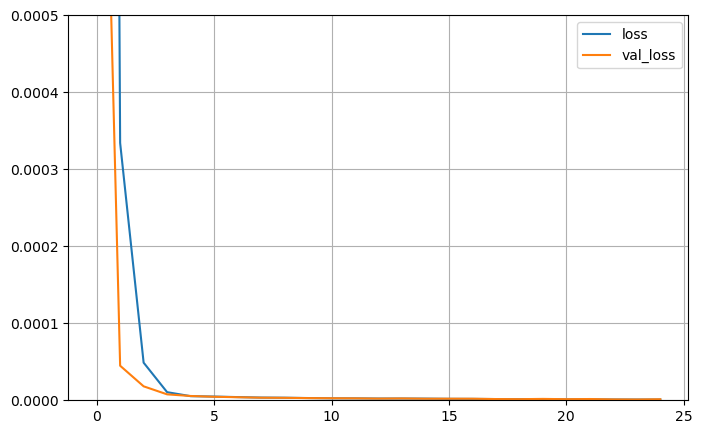

In [26]:
# Plot learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5e-4) # set the vertical range to [0-1]
plt.show()

In [27]:
mse_test = model.evaluate(X_test_scaled, y_test)
np.sqrt(mse_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4375e-06 


0.0011535271858226612

In [28]:
X_new = X_test_scaled[:3] # pretend these are new instances
y_pred = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [29]:
y_test[:3]

776    3.550781e-07
683   -3.576172e-07
912    1.003857e-06
Name: dv_st, dtype: float64

In [30]:
y_pred[:3]

array([[-0.00024553],
       [-0.00032955],
       [-0.00013052]], dtype=float32)

# Fine-Tuning Neural Network Hyperparameters

Wrap our Keras models in objects that mimic regular Scikit-Learn regressors.

def build_model(n_hidden, n_neurons, learning_rate, 
                input_shape):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", 
                                     **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

from scikeras.wrappers import KerasRegressor

keras_reg = KerasRegressor(build_model, n_hidden=1, n_neurons=30, learning_rate=3e-3, 
                input_shape=[8])

In [31]:
import keras
from keras import layers


def build_model(hp):
    model = keras.Sequential()
    #model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
               # Tune number of units separately for each layer.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
    model.add(layers.Dense(1))
    #learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        #optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        optimizer="adam",
        loss="mean_squared_error",
    )
    return model


In [32]:
# Quickly test if model builds successfuly
import keras_tuner

build_model(keras_tuner.HyperParameters())

<Sequential name=sequential_2, built=False>

Use a randomized search to train hundreds of hyperparameter combinations  and see which one performs best on the validation set.

Note that RandomizedSearchCV uses K-fold cross-validation, so it
does not use X_valid and y_valid . These are just used for early stopping.

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, 
                                   n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [33]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [34]:
# print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


Then, start the search for the best hyperparameter configuration. All the arguments passed to search is passed to model.fit() in each execution. Remember to pass validation_data to evaluate the model.

In [35]:
tuner.search(X_train_scaled, y_train, epochs=25, validation_data=(X_valid_scaled, y_valid))

Trial 20 Complete [00h 00m 06s]
val_loss: 1.0049563492486868e-07

Best val_loss So Far: 3.873984133484498e-09
Total elapsed time: 00h 02m 01s


## Query the results
When search is over, you can retrieve the best model(s). The model is saved at its best performing epoch evaluated on the validation_data.

In [36]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 192)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 288)            │        55,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 160)            │        46,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,865 (440.88 KB)

 Trainable params: 112,865 (440.88 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
tuner.results_summary()

Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 12 summary
Hyperparameters:
num_layers: 5
units_0: 192
units_1: 288
units_2: 160
units_3: 32
units_4: 128
Score: 3.873984133484498e-09

Trial 09 summary
Hyperparameters:
num_layers: 5
units_0: 160
units_1: 352
units_2: 320
units_3: 288
units_4: 160
Score: 9.530190858697551e-09

Trial 13 summary
Hyperparameters:
num_layers: 4
units_0: 224
units_1: 288
units_2: 320
units_3: 192
units_4: 480
Score: 1.2253473347101362e-08

Trial 07 summary
Hyperparameters:
num_layers: 3
units_0: 416
units_1: 448
units_2: 64
units_3: 224
Score: 1.4405406201234427e-08

Trial 03 summary
Hyperparameters:
num_layers: 4
units_0: 352
units_1: 128
units_2: 32
units_3: 32
Score: 1.6669678526426424e-08

Trial 05 summary
Hyperparameters:
num_layers: 3
units_0: 512
units_1: 256
units_2: 480
units_3: 128
Score: 1.9736329015529464e-08

Trial 18 summary
Hyperparameters:
num_layers: 4
units_0: 320
units_1

In [42]:
mse_test = best_model.evaluate(X_test_scaled, y_test)
np.sqrt(mse_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0065e-09 


4.343492698182796e-05

In [43]:
X_new = X_test_scaled[:3] # pretend these are new instances
y_pred = best_model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [44]:
y_test[:3]

776    3.550781e-07
683   -3.576172e-07
912    1.003857e-06
Name: dv_st, dtype: float64

In [45]:
y_pred[:3]

array([[-3.3189004e-05],
       [ 2.5732050e-05],
       [-3.2451397e-05]], dtype=float32)